In [1]:
import pandas as pd
import re
import numpy as np


In [2]:
colName = ['Название', 'Дата создания', 'количество', 'цена за единицу', 'Товары.1']

In [3]:
df = pd.read_csv(f"/content/ПозициивЗаказе.csv")
df = df[colName]

In [ ]:
for i in range(1, 9):
    path = f"/Users/davidmarshalov/Desktop/Мага/gnn/ПозициивЗаказе ({i}).csv"
    dfLocal = pd.read_csv(path)
    dfLocal = dfLocal[colName]
    df = pd.concat([df, dfLocal], axis=0)


In [ ]:
#df.drop_duplicates(inplace=True)
#df.rename(columns={"Товары.1":"Товары"}, inplace=True)

In [ ]:
df.iloc[[1, 33, 44444]]


,Название,Дата создания,количество,цена за единицу,Товары
1,позиция заказа № 647892 от 12.09.25 11:07,12.09.2025 11:09,1,"руб 1,399.00","Фирменная, 45"
33,позиция заказа № 647901 от 12.09.25 12:59,12.09.2025 13:02,1,руб 449.00,Роллы Америка
2406,позиция заказа № 631912 от 12.02.25 18:22,12.02.2025 18:24,1,"руб 1,099.00","Четыре сыра, 45"


In [ ]:
df["Название"] = df["Название"].str.extract(r"№\s*(\d+)", expand=False)
dt = pd.to_datetime(df["Дата создания"], dayfirst=True)

df["Дата"] = dt.dt.date
df["Время"] = dt.dt.time
df = df.drop(columns=["Дата создания"])

df["цена за единицу"] = (
    df["цена за единицу"]
      .str.replace("руб", "", regex=False)
      .str.replace(" ", "", regex=False)
      .str.replace(",", "", regex=False)
      .astype(float)
)



In [ ]:
def normalize_item(name: str) -> str:

    if pd.isna(name):
        return np.nan

    s = name.strip().lower()

    # убрать "1/2 " в начале
    s = re.sub(r'^1/2\s+', '', s)

    # убрать объём/размер в конце: ", 45", ", 33", " 45", " 33", " 0.5 л", " 1 л", " 33 см", " 45 см"
    s = re.sub(r',?\s*\d+\s*(см|л)?\.?$', '', s)

    # убрать "мл" в конце: "250мл", "250 мл", "220мл."
    s = re.sub(r'\s*\d+\s*мл\.?$', '', s)

    # привести множественные пробелы к одному
    s = re.sub(r'\s+', ' ', s).strip()

    # явные синонимы/похожие варианты → одно название
    replacements = {
        "доставка 49": "доставка",
        "доставка": "доставка",
        "сервисный сбор": "сервисный сбор",
        "сервисный сбор от 10т": "сервисный сбор",

        # газировки
        "кока-кола": "кока-кола",
        "кола": "кока-кола",
        "кола 250": "кока-кола",
        "любимый кола": "кока-кола",   # при желании можно оставить отдельно
        "фанта": "фанта",
        "спрайт": "спрайт",
        "ред булл": "red bull",

        # вода
        "бон-аква без газа": "бон-аква",
        "бон-аква с газом": "бон-аква",
        "бон аква": "бон-аква",

        # пиццы — снятие размера/половинки уже сделано regex
        "пицца барбекю": "пицца барбекю",
        "маргарита": "маргарита",
        "пепперони": "пепперони",
        "четыре сыра": "четыре сыра",
        "деревенская": "деревенская",
        "классическая": "классическая",
        "времена года": "времена года",
        "шпинат": "шпинат",
        "охотничья": "охотничья",
        "фелиция": "фелиция",
        "детская": "детская",
        # при желании можно добавить ещё явные группы
    }

    # если после обрезки получилось что-то вроде "кола", "кола 250" и т.п.
    # можно ещё чуть нормализовать:
    if s.startswith("кола"):
        s = "кола"
    if s.startswith("фанта"):
        s = "фанта"
    if s.startswith("спрайт"):
        s = "спрайт"
    if s.startswith("бон-аква") or s.startswith("бон аква"):
        s = "бон аква"

    # применяем словарь с синонимами, если есть
    s = replacements.get(s, s)

    # финально — делаем красивый регистр
    s = s.capitalize()

    return s


In [ ]:
# --- 1. список "мусорных" / малоинформативных позиций ---
LOW_INFO_PATTERNS = [
    r'\bдоставка\b',          # доставка, доставка 49
    r'сервисный сбор',        # сервисный сбор, сервисный сбор от 10т
]

def is_low_info(clean_name: str) -> bool:
    for pat in LOW_INFO_PATTERNS:
        if re.search(pat, clean_name):
            return True
    return False


# --- 2. базовая очистка и склейка похожих названий ---
def normalize_item(name):
    # пропуски сразу возвращаем
    if pd.isna(name):
        return np.nan

    # приводим к строке и в нижний регистр
    s = str(name).strip().lower()

    # убрать "1/2 " в начале (1/2 пиццы)
    s = re.sub(r'^1/2\s+', '', s)

    # убрать размер/вес/объём в конце:
    # ", 45", ", 33", " 45", " 33", " 33 см", " 45 см", " 1 л", "0.5 л"
    s = re.sub(r',?\s*\d+\s*(см|l|л)?\.?$', '', s)

    # убрать "250мл", "250 мл", "220мл." в конце
    s = re.sub(r'\s*\d+\s*мл\.?$', '', s)

    # обрезать лишние пробелы
    s = re.sub(r'\s+', ' ', s).strip()

    # --- 2.1. объединяем похожие варианты по префиксам/паттернам ---

    # газировка
    if s.startswith("кока-кола") or s.startswith("кола"):
        s = "кока-кола"
    elif s.startswith("фанта"):
        s = "фанта"
    elif s.startswith("спрайт"):
        s = "спрайт"
    elif "бон-аква" in s or "бон аква" in s:
        s = "бон-аква"

    # пиво (можно склеить в одно "пиво", при желании разбить по брендам)
    elif "балтика 3" in s or "старый мельник" in s or "туборг" in s or "миллер" in s \
         or "хугарден" in s or "велкопоповецкий козел" in s or "жигули барное" in s:
        s = "пиво"

    # соки по фрукту без бренда
    elif "яблоко" in s:
        s = "сок яблоко"
    elif "апельсин" in s:
        s = "сок апельсин"
    elif "вишня" in s:
        s = "сок вишня"
    elif "персик" in s:
        s = "сок персик"

    # чизкейки
    elif s.startswith("чизкейк"):
        s = "чизкейк"

    # кофе
    elif s == "американо" or "американо" in s:
        s = "кофе американо"
    elif "латте" in s:
        s = "кофе латте"
    elif s == "кофе" or "кофе растворимый" in s:
        s = "кофе"

    # лапша – по типу лапши, без мяса
    elif "лапша гречневая" in s:
        s = "лапша гречневая"
    elif "лапша яичная" in s:
        s = "лапша яичная"
    elif "лапша пшеничная" in s:
        s = "лапша пшеничная"
    elif "лапша стеклянная" in s or "фунчоза" in s:
        s = "лапша фунчоза"

    # роллы/суши – основные категории
    elif s.startswith("роллы "):
        # оставляем как есть (имя ролла), но уже без размеров и т.п.
        pass
    elif s.startswith("суши "):
        # суши тоже оставляем по имени
        pass

    # пицца: убрали размеры, оставим название
    elif "пицца барбекю" in s:
        s = "пицца барбекю"
    elif "четыре сыра" in s:
        s = "четыре сыра"
    elif "маргарита" in s:
        s = "маргарита"
    elif "деревенская" in s:
        s = "деревенская"
    elif "классическая" in s:
        s = "классическая"
    elif "охотничья" in s:
        s = "охотничья"
    elif "фелиция" in s:
        s = "фелиция"
    elif "времена года" in s:
        s = "времена года"
    elif "детская" in s:
        s = "детская"
    elif "шпинат" in s:
        s = "шпинат"
    elif "пепперони" in s:
        s = "пепперони"

    # всё что явно сервис/доставка – помечаем как пропуск
    if is_low_info(s):
        return np.nan

    # если после чистки пусто — тоже пропуск
    if not s:
        return np.nan

    # первая буква заглавная, остальное как есть
    s = s[0].upper() + s[1:]

    return s



In [ ]:
df["Товары_норм"] = df["Товары_норм"].apply(normalize_item)


In [ ]:
def standardize_name(name):
    if pd.isna(name):
        return np.nan

    s = str(name).strip()

    # 1) объединяем крылышки
    if s in ["Крылышки жаренные 8 шт.", "Крылышки жаренные 6 шт."]:
        return "Крылышки жаренные"

    # 2) убираем "Сет-"
    if s == "Сет-":
        return np.nan

    # 3) исправляем явные опечатки
    if s == "Охотничая":
        return "Охотничья"

    if s == "Соус терияри":
        return "Соус терияки"

    # остальное оставляем как есть
    return s

df["Товары_норм"] = df["Товары_норм"].apply(standardize_name)


In [ ]:
to_remove = [
    "Овощи с курицей",
    "Огурцы соленые",
    "Рис с овощами",
    "Салями",
    "Сыр дорблю",
    "Red bull",
    "Сэндвич с авокадо",
    "Охотничьи колбаски",
    "Соус кимчи",
    "Огурец",
    "Балтика 0",
    "Сок персик",
    "Сыр швейцарский",
    "Краковская колбаса",
    "Перец болгарский",
    "Соус терияки",
    "Говядина",
    "Гранат",
    "Суп хашлама",
    "Сенсей",
    "Кокосовое молоко",
    "Яйцо"
]

# если работаешь с уже нормализованным столбцом
df["Товары_норм"] = df["Товары_норм"].apply(lambda x: np.nan if x in to_remove else x)


In [ ]:
dfCount = pd.DataFrame(df['Товары_норм'].value_counts()).reset_index()

In [ ]:
#df.dropna(inplace=True)
#df = df.reset_index().drop(columns='index')
#df = df.sort_values('Дата', ascending=False)
#df.drop(columns='Товары', inplace=True)

In [ ]:
df.iloc[:10, :]

,Название,количество,цена за единицу,Дата,Время,Товары_норм
5732,650285,1,0.0,2025-10-12,13:35:00,Темпура дракон
5758,650291,1,399.0,2025-10-12,15:00:00,Роллы чука-сан
5783,650295,2,529.0,2025-10-12,15:45:00,Роллы калифорния креветка
5782,650295,1,999.0,2025-10-12,15:45:00,Закрытая
5781,650295,2,0.0,2025-10-12,15:45:00,Соус сливочный
5780,650295,2,118.0,2025-10-12,15:45:00,Гренки с чесноком
5779,650294,1,0.0,2025-10-12,15:35:00,Темпура дракон
5778,650294,1,499.0,2025-10-12,15:35:00,Роллы фуджи
5777,650294,1,120.0,2025-10-12,15:35:00,Суши креветка спайс
5776,650294,1,399.0,2025-10-12,15:35:00,Роллы острый с креветкой


In [ ]:
df

,Название,количество,цена за единицу,Дата,Время,Товары_норм
5732,650285,1,0.0,2025-10-12,13:35:00,Темпура дракон
5758,650291,1,399.0,2025-10-12,15:00:00,Роллы чука-сан
5783,650295,2,529.0,2025-10-12,15:45:00,Роллы калифорния креветка
5782,650295,1,999.0,2025-10-12,15:45:00,Закрытая
5781,650295,2,0.0,2025-10-12,15:45:00,Соус сливочный
...,...,...,...,...,...,...
45307,628576,3,45.0,2025-01-02,19:29:00,Соус сливочный
45306,628576,2,179.0,2025-01-02,19:29:00,Картофель фри
45305,628574,1,268.0,2025-01-02,19:28:00,Тирамису
45304,628574,1,120.0,2025-01-02,19:28:00,Чай


In [ ]:
df.rename(columns={'Название':'order_id',
                   'количество':'количество',
                   'цена за единицу':'цена',
                   'Дата':'дата',
                   'Время':'время',
                   'Товары_норм':'товар',}, inplace=True)

In [ ]:
#df.to_excel('/Users/davidmarshalov/Desktop/Мага/gnn/df.xlsx')

In [4]:
df = pd.read_excel('/content/df.xlsx')

In [5]:
df.drop(columns='Unnamed: 0', inplace=True)

In [6]:
df

,order_id,количество,цена,дата,время,товар
0,650285,1,0,2025-10-12,13:35:00,Темпура дракон
1,650291,1,399,2025-10-12,15:00:00,Роллы чука-сан
2,650295,2,529,2025-10-12,15:45:00,Роллы калифорния креветка
3,650295,1,999,2025-10-12,15:45:00,Закрытая
4,650295,2,0,2025-10-12,15:45:00,Соус сливочный
...,...,...,...,...,...,...
51501,628576,3,45,2025-01-02,19:29:00,Соус сливочный
51502,628576,2,179,2025-01-02,19:29:00,Картофель фри
51503,628574,1,268,2025-01-02,19:28:00,Тирамису
51504,628574,1,120,2025-01-02,19:28:00,Чай


In [ ]:
#для составления комбо на зиму#
#df = df[(df['дата'] < "2025-02-01") | (df['дата'] > "2025-09-01")]

In [7]:
df = df[df["цена"] != 0] #не учитываю дополнения бесплатные (подарки)

In [8]:
orders_series = df.groupby('order_id')['товар'].apply(list)
orders_list = orders_series.tolist()

print(len(orders_list), "заказов")
print(orders_list[:3])  # первые 3 корзины


12613 заказов
[['Классическая', 'Роллы флорида'], ['Роллы филадельфия', 'Роллы калифорния креветка', 'Картофель по-деревенски', 'Луковые кольца'], ['Кока-кола', 'Шашлычок из курицы', 'Мясной микс']]


In [9]:
#граф совместных покупок
from collections import Counter
import itertools
from collections import defaultdict


In [10]:
#если 2 товара встречаются  в одном заказе  стравим ребро между ними и устанавливаем веса ребров по количеству совместных заказов
pair_counter = Counter()

for items in orders_list:
    unique_items = list(set(items))
    #комбинируем без повтором и учета порядка
    for a, b in itertools.combinations(unique_items, 2):
        if a > b:
            a, b = b, a  # чтобы (a,b) и (b,a) не дублировались
        pair_counter[(a, b)] += 1

print("Число пар:", len(pair_counter))


Число пар: 11554


In [42]:
top_10_pairs = dict(sorted(pair_counter.items(), key=lambda x: x[1], reverse=True)[:5])

for pair, count in top_10_pairs.items():
    print(f"{pair}: {count}")

('Роллы калифорния креветка', 'Роллы эби-темпура'): 509
('Роллы монблан', 'Роллы нежный'): 415
('Роллы монблан', 'Роллы эби-темпура'): 405
('Картофель фри', 'Соус сливочный'): 368
('Роллы нежный', 'Роллы эби-темпура'): 359


In [12]:
item_counter = Counter()

for items in orders_list:
    for item in items:
        item_counter[item] += 1

print("Число уникальных товаров:", len(item_counter))


Число уникальных товаров: 199


In [ ]:
#   edge_df.to_excel('/Users/davidmarshalov/Desktop/Мага/gnn/edgeDF.xlsx')

In [ ]:
#Функция item-based рекомендаций по косинусному сходству

#использу/ коэффициент Жаккара как меру похожести двух товаров
#sim(a,b) = cooc(a,b) / (freq(a) + freq(b) - cooc(a,b))

In [13]:
# из pair_counter делаем индекс удобный для поиска (соседи для каждого)
neighbors = defaultdict(dict)
for (a, b), w in pair_counter.items():
    neighbors[a][b] = w
    neighbors[b][a] = w

In [14]:
#Жаккара коэф для измерения похожести
def jaccard_sim(a, b, cooc, item_freq):
    inter = cooc #сколько заказов было вместе (пересечение)
    denom = item_freq[a] + item_freq[b] - cooc #сколько заказов, где есть хотя бы один из них
    return inter / denom if denom > 0 else 0.0

def recommend_item_based(target_item, top_k=5, min_cooc=2):
    if target_item not in item_counter:
        print("Товар не найден в данных:", target_item)
        return []

    sims = []
    for other, cooc in neighbors[target_item].items():
        if cooc < min_cooc:
            continue
        sim = jaccard_sim(target_item, other, cooc, item_counter)
        sims.append((other, sim, cooc))

    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:top_k]

print("Рекомендации (item-based):")
print(recommend_item_based("Темпура дракон", top_k=5))


Рекомендации (item-based):
[('Роллы кирин', 0.004106776180698152, 2), ('Роллы калифорния креветка', 0.0012903225806451613, 2), ('Роллы монблан', 0.0012084592145015106, 2), ('Роллы эби-темпура', 0.001006036217303823, 2)]


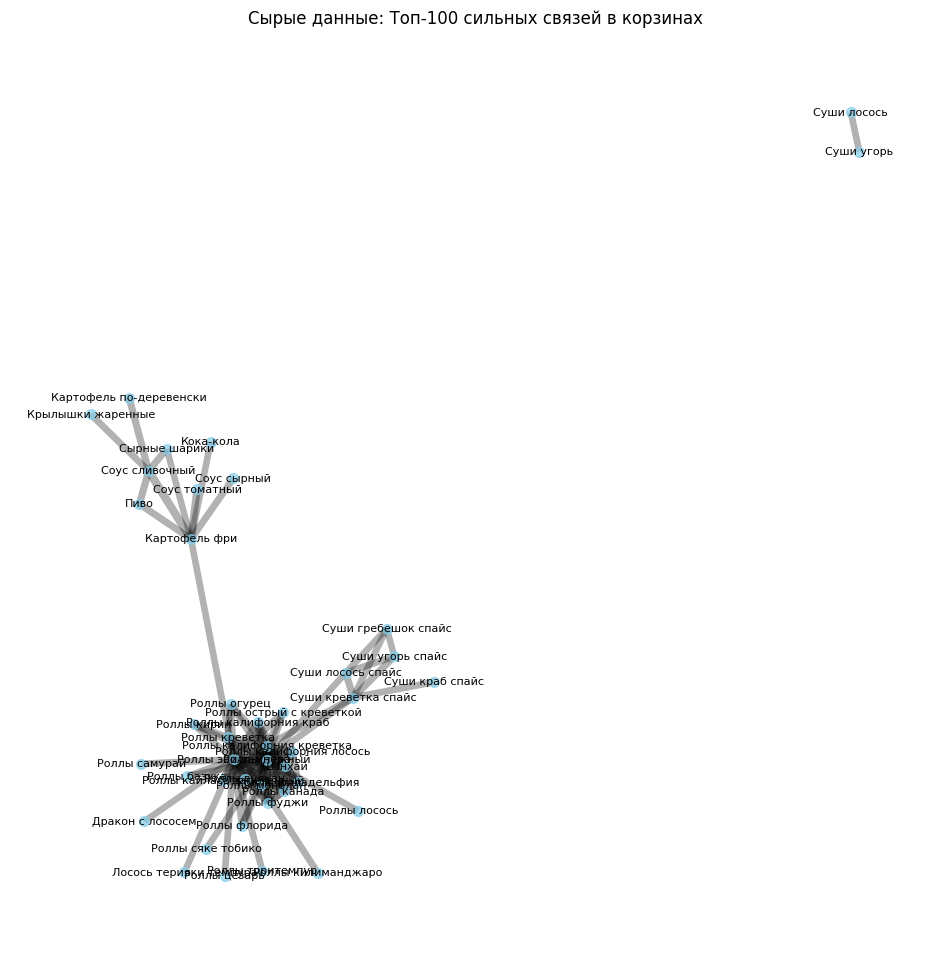

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_smart_graph(pair_counter, max_edges=70, min_weight=10):
    G = nx.Graph()

    trash_items = {'Соевый соус', 'Имбирь', 'Васаби', 'Палочки'}

    filtered_pairs = [
        ((a, b), w) for (a, b), w in pair_counter.items()
        if a not in trash_items and b not in trash_items and w >= min_weight
    ]
    sorted_pairs = sorted(filtered_pairs, key=lambda x: x[1], reverse=True)[:max_edges]

    for (a, b), w in sorted_pairs:
        G.add_edge(a, b, weight=w)

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=2.0, seed=42)

    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    weights = [log(w + 1) * 1.5 for _, _, w in G.edges(data='weight')]
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.4, edge_color='gray')

    plt.title("Очищенный граф связей товаров")
    plt.axis('off')
    plt.show()

from math import log
plot_item_graph(pair_counter, "Сырые данные: Топ-100 сильных связей в корзинах")

In [ ]:
#несмотря на высокое абслютное значение совместных заказов коэф все равно меньше
#потому что товары (не таргеты) сами по себе популярны

In [ ]:
#проблема Жаккара в том что он смотрит только на каждую позицию отдельно  и не видит общей структуры (более 2 товаров)
#которые гуляют в похожиъ чанках
#
#
#

In [18]:
#pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 62.6 MB/s eta 0:00:00


In [19]:
#Word2Vec
from gensim.models import Word2Vec

Делаю списки совместно встречающихся слов и обучаю модель
Идея следующая, если слова часто встречаются в одном контексте их векторы должны быть похожими

в итоге получим для каждого слова вектор и сможем оценить схожесть векторов

In [20]:
# используем последовательности товаров (как предложения)
sentences = [list(map(str, items)) for items in orders_list]

In [21]:
max(list(len(items) for items in orders_list))

29

In [22]:
df

,order_id,количество,цена,дата,время,товар
1,650291,1,399,2025-10-12,15:00:00,Роллы чука-сан
2,650295,2,529,2025-10-12,15:45:00,Роллы калифорния креветка
3,650295,1,999,2025-10-12,15:45:00,Закрытая
5,650295,2,118,2025-10-12,15:45:00,Гренки с чесноком
7,650294,1,499,2025-10-12,15:35:00,Роллы фуджи
...,...,...,...,...,...,...
51501,628576,3,45,2025-01-02,19:29:00,Соус сливочный
51502,628576,2,179,2025-01-02,19:29:00,Картофель фри
51503,628574,1,268,2025-01-02,19:28:00,Тирамису
51504,628574,1,120,2025-01-02,19:28:00,Чай


In [23]:
#так как позиции в заказе не меют между собй никакого смысла  мы взяли макс окно по заказам чтобы совместные заказы товаров имели в векторном пространве близкие расстояния

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=128,
    window=29,
    min_count=2,   # игнорировать очень редкие
    workers=4,
    sg=1,          # skip-gram
    epochs=100
)


In [24]:
def recommend_word2vec(target_item, top_k=5):
    if target_item not in w2v_model.wv:
        print("Нет эмбеддинга для товара:", target_item)
        return []
    return w2v_model.wv.most_similar(target_item, topn=top_k)

print("Рекомендации (Word2Vec):")
print(recommend_word2vec("Темпура дракон", top_k=5))


Рекомендации (Word2Vec):
[('Буженина', 0.5254813432693481), ('Бекон', 0.49593597650527954), ('Помидор', 0.45705217123031616), ('Грибы(шампиньоны)', 0.43459582328796387), ('Лосось', 0.42523401975631714)]


In [ ]:
#сжимает всю инфу в компактный вектор для каждого товара который содержит инфомрацию о том с кем он встречается в каких типах чеков в каких комбинациях - более осмысленный вектор (инфмаормативный)
#
#

In [ ]:
#попали примерно те же товары что и при классическом подходе

In [26]:
#pip install -q torch-scatter torch-sparse torch-geometric
#!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.5 MB/s eta 0:00:00


In [27]:
from torch_geometric.data import Data
import torch

#GNN (GCN) на графе товаров

#Используем PyTorch Geometric.
#Граф:

#узлы – товары,

#рёбра – co-purchase (из pair_counter),

#признаки узлов – эмбеддинги Word2Vec (если есть), иначе one-hot fallback.

In [28]:
# строим узлы и их признаки
#
#В качестве признаков берем эмбеддинги Word2Vec
#
#

items = list(item_counter.keys())
item2idx = {item: i for i, item in enumerate(items)}
idx2item = {i: item for item, i in item2idx.items()}

num_nodes = len(items)
embed_dim = 128

# X: матрица признаков [num_nodes, embed_dim]
X = torch.zeros((num_nodes, embed_dim), dtype=torch.float)

for item, idx in item2idx.items():
    if item in w2v_model.wv:
        X[idx] = torch.tensor(w2v_model.wv[item])
    else:
        # редкий товар: можно оставить нули или добавить небольшую шумовую инициализацию
        X[idx] = torch.randn(embed_dim) * 0.01


In [29]:
#строим неориентированный граф (по смыслу)
#
#


edge_list = []
edge_weight_list = []

min_cooc = 2

for (a, b), w in pair_counter.items():
    if w < min_cooc:
        continue
    i = item2idx[a]
    j = item2idx[b]
    # неориентированный граф – добавляем два направления так как GCN в PyG работает
    #с направленными рёбрами
    edge_list.append([i, j])
    edge_list.append([j, i])
    edge_weight_list.append(w)
    edge_weight_list.append(w)

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()  # [2, E]
edge_weight = torch.tensor(edge_weight_list, dtype=torch.float)

print(edge_index.shape, edge_weight.shape)


torch.Size([2, 17492]) torch.Size([17492])


In [30]:
from torch_geometric.nn import GCNConv

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x  # эмбеддинги узлов


In [31]:
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_g = Data(x=X, edge_index=edge_index).to(device)
edge_index = data_g.edge_index
x = data_g.x

encoder = GCNEncoder(in_channels=embed_dim, hidden_channels=64, out_channels=32).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01, weight_decay=5e-4)

# список уникальных положительных рёбер без дубликатов
pos_edges = edge_index.t().cpu().numpy()
pos_edges = { (int(i), int(j)) for i, j in pos_edges if i != j }

all_nodes = list(range(num_nodes))

def sample_negative_edges(num_samples):
    neg_edges = set()
    while len(neg_edges) < num_samples:
        i = random.choice(all_nodes)
        j = random.choice(all_nodes)
        if i == j:
            continue
        if (i, j) in pos_edges or (j, i) in pos_edges:
            continue
        neg_edges.add((i, j))
    return list(neg_edges)

bce = torch.nn.BCEWithLogitsLoss()

def train_link_prediction(num_epochs=100, neg_pos_ratio=1):
    encoder.train()
    for epoch in range(1, num_epochs+1):
        optimizer.zero_grad()
        z = encoder(x, edge_index)  # [N, d]

        pos_list = list(pos_edges)
        random.shuffle(pos_list)
        pos_sample = pos_list[:2000] if len(pos_list) > 2000 else pos_list

        neg_sample = sample_negative_edges(len(pos_sample) * neg_pos_ratio)

        # формируем батч пар
        src = [i for i, j in pos_sample] + [i for i, j in neg_sample]
        dst = [j for i, j in pos_sample] + [j for i, j in neg_sample]
        labels = [1]*len(pos_sample) + [0]*len(neg_sample)

        src = torch.tensor(src, dtype=torch.long, device=device)
        dst = torch.tensor(dst, dtype=torch.long, device=device)
        labels = torch.tensor(labels, dtype=torch.float, device=device)

        # скалярное произведение как предсказание наличия связи
        scores = (z[src] * z[dst]).sum(dim=1)

        loss = bce(scores, labels)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == 1:
            with torch.no_grad():
                pred = (scores > 0).float()
                acc = (pred == labels).float().mean().item()
            print(f"Epoch {epoch:03d}: loss={loss.item():.4f}, lp-acc={acc:.4f}")

train_link_prediction(num_epochs=100)


Epoch 001: loss=0.6790, lp-acc=0.5000
Epoch 010: loss=0.5872, lp-acc=0.6308
Epoch 020: loss=0.5521, lp-acc=0.6600
Epoch 030: loss=0.5159, lp-acc=0.7200
Epoch 040: loss=0.4778, lp-acc=0.7542
Epoch 050: loss=0.4702, lp-acc=0.7602
Epoch 060: loss=0.4772, lp-acc=0.7527
Epoch 070: loss=0.4605, lp-acc=0.7653
Epoch 080: loss=0.4555, lp-acc=0.7675
Epoch 090: loss=0.4618, lp-acc=0.7678
Epoch 100: loss=0.4629, lp-acc=0.7673


In [32]:
encoder.eval()
with torch.no_grad():
    z = encoder(x, edge_index).cpu()
z.shape  # [num_nodes, 32]


torch.Size([199, 32])

In [33]:
import torch
from torch.nn.functional import cosine_similarity


In [34]:
def recommend_gnn(target_item, z, item2idx, idx2item, top_k=5):
    if target_item not in item2idx:
        print("Товар не найден:", target_item)
        return []

    target_idx = item2idx[target_item]
    target_vec = z[target_idx].unsqueeze(0)  # [1, d]

    # косинусная похожесть со всеми товарами
    sims = cosine_similarity(target_vec, z)  # [num_nodes]

    # превращаем в список (idx, sim)
    sims_list = [(i, float(sims[i])) for i in range(len(sims)) if i != target_idx]

    # сортируем по похожести по убыванию
    sims_list.sort(key=lambda x: x[1], reverse=True)

    # берем топ-k
    top = sims_list[:top_k]

    # переводим индексы обратно в названия
    results = [(idx2item[i], sim) for i, sim in top]
    return results


In [35]:
encoder.eval()
with torch.no_grad():
    z = encoder(x, edge_index).cpu()  # [num_nodes, d]

print("GNN-рекомендации для 'Темпура дракон':")
print(recommend_gnn("Темпура дракон", z, item2idx, idx2item, top_k=5))


GNN-рекомендации для 'Темпура дракон':
[('Гречневая лапша с говядиной', 0.9995575547218323), ('Ореховый соус', 0.9994608163833618), ('Лук', 0.999445915222168), ('Тирамису', 0.9992287755012512), ('Роллы аризона', 0.9991763830184937)]


In [ ]:
print(recommend_gnn("Дракон с угрем", z, item2idx, idx2item, top_k=5))

[('Роллы флорида', 0.9999525547027588), ('Роллы острый с креветкой', 0.9997029304504395), ('Роллы острый морской', 0.999701201915741), ('Роллы угорь', 0.9996599555015564), ('Роллы базука', 0.9996389150619507)]


In [ ]:
#1 метод [('Филадельфия микс', 0.05116279069767442, 11), ('Дракон с угрем', 0.04552590266875981, 29), ('Абу-даби', 0.04072398190045249, 9), ('Пучина', 0.03225806451612903, 7), ('Лосось терияки темпура', 0.02949438202247191, 21)]
#2 метод [('Пучина', 0.44427457451820374), ('Роллы острый вулкан', 0.43270817399024963), ('Стейк пицца', 0.41024813055992126), ('Абу-даби', 0.3588361144065857), ('Роллы монблан', 0.29913508892059326)]
#3 метод [('Роллы мэдисон', 0.9999738931655884), ('Дракон с угрем', 0.9999731183052063), ('Роллы бамбук', 0.9999690651893616), ('Сейко', 0.99996417760849), ('Дракон с лососем', 0.9999608993530273)]


1 - Жаккар смотрит только на факт совместных заказов. То есть сколько раз таргет встречался с b товаром и делаит на общее число заказов (т е он не знает ничего про остальные товары и структуру графа есть инфа только про пары)

2 -


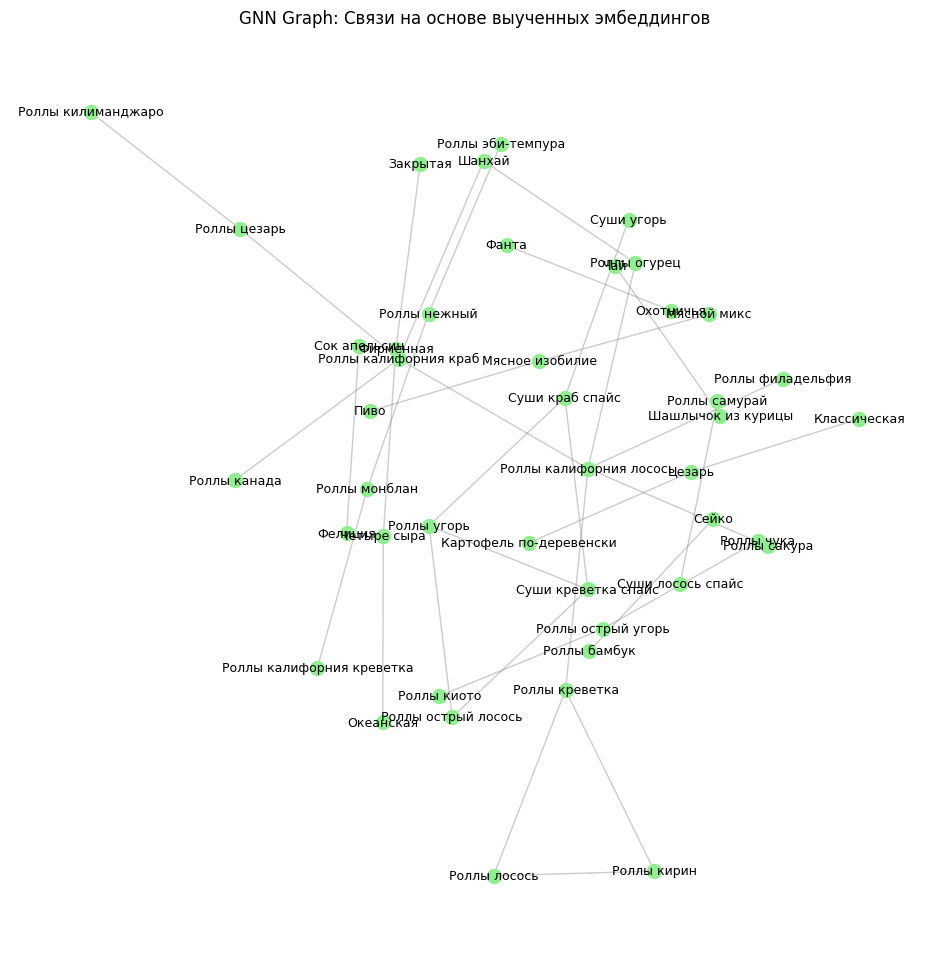

In [36]:
def plot_gnn_similarity_graph(z, idx2item, top_k_neighbors=2, max_nodes=50):
    """
    Строит граф, где связи — это топ-K ближайших соседей по мнению GNN
    """
    from sklearn.metrics.pairwise import cosine_similarity
    import numpy as np

    G = nx.Graph()
    sim_matrix = cosine_similarity(z)

    # Чтобы не рисовать всё, возьмем первые 50 товаров или случайные
    nodes_to_show = list(range(min(max_nodes, len(idx2item))))

    for i in nodes_to_show:
        # Находим индексы самых похожих товаров для узла i
        sim_scores = sim_matrix[i]
        # Берем top_k + 1 (так как самый похожий — это сам товар)
        closest_indices = np.argsort(sim_scores)[-(top_k_neighbors+1):-1]

        for j in closest_indices:
            if j in nodes_to_show:
                G.add_edge(idx2item[i], idx2item[j], weight=float(sim_scores[j]))

    plt.figure(figsize=(12, 12))
    pos = nx.kamada_kawai_layout(G) # Хорошо распределяет узлы по сходству

    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightgreen')
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=9)

    plt.title("GNN Graph: Связи на основе выученных эмбеддингов")
    plt.axis('off')
    plt.show()

# Запускаем для ваших эмбеддингов z
plot_gnn_similarity_graph(z.numpy(), idx2item, top_k_neighbors=2, max_nodes=60)

Полученные результаты визуализации и кластеризации наглядно показывают, что GNN успешно структурировала ассортимент, превратив сырой граф совместных покупок в осмысленную карту смысловых групп. Если на исходном графе мы видели хаотичные связи, где популярные позиции просто стягивали всё на себя, то после обучения на эмбеддингах выделились четкие кластеры. Например, Кластер 0 объединил классические роллы и фастфуд (картофель фри, наггетсы), Кластер 2 сгруппировал острые суши и тематические роллы («Киото», «Сакура»), а Кластер 5 четко выделил категорию пиццы и добавок к ней. ГРАФ GNN-связей показывает нам не просто частоту покупок, а похожесть товаров по их роли в потреблении: модель поняла, что даже если два товара редко встречаются в одной корзине, они могут быть похожи, потому что их покупают с одними и теми же сопутствующими позициями. Это делает такие рекомендации гораздо глубже и точнее, чем простой подсчет статистики, позволяя предлагать клиенту не только то, что берут все, но и товары, максимально близкие по вкусовому профилю

In [37]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


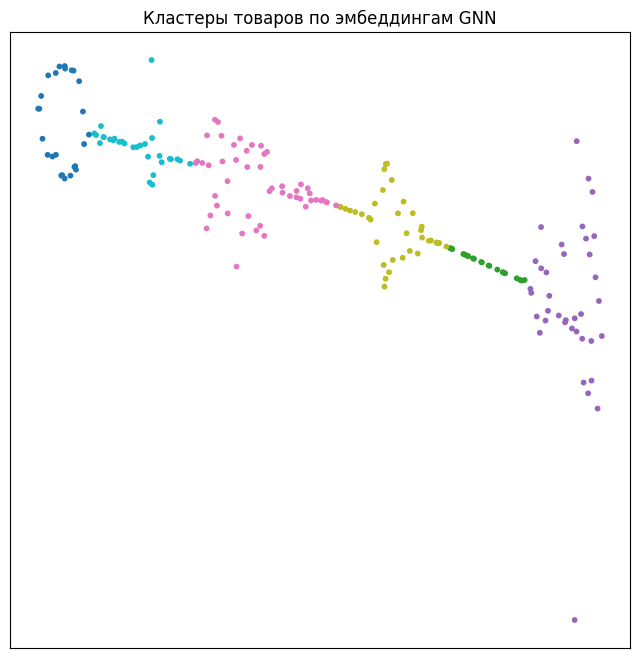

In [38]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
z_2d = tsne.fit_transform(z.numpy())

# kMeans
num_clusters = 6  # можно подобрать
km = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = km.fit_predict(z.numpy())

plt.figure(figsize=(8, 8))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.xticks([]); plt.yticks([])
plt.title("Кластеры товаров по эмбеддингам GNN")
plt.show()



In [ ]:
cluster_items = {c: [] for c in range(num_clusters)}
for idx, c in enumerate(cluster_labels):
    item_name = idx2item[idx]
    cluster_items[c].append(item_name)

for c in range(num_clusters):
    print(f"\nКластер {c}:")
    print(", ".join(cluster_items[c]))  # первые 15 товаров кластера



Кластер 0:
Кока-кола, Суп том ям, Роллы нежный, Роллы огурец, Роллы самурай, Роллы эби-темпура, Шанхай, Роллы калифорния креветка, Роллы цезарь, Мясное изобилие, Роллы калифорния краб, Роллы монблан, Роллы килиманджаро, Пиво, Роллы филадельфия, Роллы калифорния лосось, Роллы кирин, Роллы канада, Роллы флорида, Роллы креветка, Роллы гималаи, Роллы кайласа запеченный, Роллы вулкан, Соус сливочный, Картофель фри, Роллы фудзияма, Сырные шарики, Роллы острый с креветкой, Роллы фуджи, Роллы америка, Роллы базука, Дракон с угрем, Лосось терияки темпура

Кластер 1:
Охотничья, Суши гребешок, Салат кайсо, Сок апельсин, Фелиция, Сок вишня, Роллы роллофф, Салат кэйнику томато, Кольца кальмара, Стейк лосось, Салат с курицей терияки, Окунь запеченный, Суп мисо рыбный, Суши тобико чёрная, Суши тобико красная, Рис тигровые креветки, Суши кунсей, Суши краб, Сок яблоко, Лапша яичная, Суп мисо классический, Времена года, Чизкейк, Суши креветка, Суши чука, Куриное изобилие, Грибочки жареные, Имбирь, Сала

In [ ]:
print(recommend_gnn("Роллы калифорния креветка", z, item2idx, idx2item, top_k=5))

[('Роллы нежный', 0.9999628663063049), ('Шанхай', 0.9999394416809082), ('Роллы канада', 0.9993308782577515), ('Роллы острый с креветкой', 0.9992018342018127), ('Роллы креветка', 0.9991859197616577)]


In [ ]:
from itertools import combinations
from collections import Counter

In [ ]:
comb2 = Counter()
comb3 = Counter()
comb4 = Counter()

for items in orders_list:
    uniq = list(set(items))  # чтобы один товар не дублировался в комбо
    for c in combinations(uniq, 2):
        comb2[tuple(sorted(c))] += 1
    for c in combinations(uniq, 3):
        comb3[tuple(sorted(c))] += 1
    for c in combinations(uniq, 4):
        comb4[tuple(sorted(c))] += 1


In [ ]:
top2 = comb2.most_common(5)
top3 = comb3.most_common(5)
top4 = comb4.most_common(5)


In [ ]:
print(recommend_gnn("Роллы калифорния креветка", z, item2idx, idx2item, top_k=5))

[('Роллы нежный', 0.9999628663063049), ('Шанхай', 0.9999394416809082), ('Роллы канада', 0.9993308782577515), ('Роллы острый с креветкой', 0.9992018342018127), ('Роллы креветка', 0.9991859197616577)]


In [ ]:
top2

[(('Роллы калифорния креветка', 'Роллы эби-темпура'), 136),
 (('Роллы монблан', 'Роллы эби-темпура'), 124),
 (('Роллы монблан', 'Роллы нежный'), 124),
 (('Роллы нежный', 'Роллы эби-темпура'), 97),
 (('Роллы калифорния креветка', 'Роллы нежный'), 94)]

In [ ]:
top3

[(('Роллы калифорния креветка', 'Роллы монблан', 'Роллы эби-темпура'), 34),
 (('Роллы монблан', 'Роллы нежный', 'Роллы эби-темпура'), 33),
 (('Роллы калифорния креветка', 'Роллы нежный', 'Роллы эби-темпура'), 32),
 (('Роллы калифорния креветка', 'Роллы креветка', 'Роллы эби-темпура'), 30),
 (('Суши креветка спайс', 'Суши лосось спайс', 'Суши угорь спайс'), 29)]

In [ ]:
top4

[(('Роллы лосось', 'Суши икура', 'Суши лосось', 'Суши угорь'), 17),
 (('Суши краб спайс',
   'Суши креветка спайс',
   'Суши лосось спайс',
   'Суши угорь спайс'),
  15),
 (('Роллы калифорния креветка',
   'Роллы монблан',
   'Роллы нежный',
   'Роллы эби-темпура'),
  12),
 (('Суши гребешок спайс',
   'Суши краб спайс',
   'Суши лосось спайс',
   'Суши угорь спайс'),
  12),
 (('Суши гребешок спайс',
   'Суши креветка спайс',
   'Суши лосось спайс',
   'Суши угорь спайс'),
  12)]